# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *
from make_plots import *
from kerasAC.splits import *

import plotnine
from plotnine import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Prepare Scores

In [2]:
explain_score = []
ism_score = []
delta_score = []
snp_cluster = []
snp_fold = []
snp_index = []

for cluster_input in range(1, 25):

    cluster = str(cluster_input)
    print("Cluster ", cluster)
    
    effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
    effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
    effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]
    
    noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
    noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
    noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

    for fold in range(10):
        effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
        effect_scores = get_hyp_scores(effect_file, effect_seqs)
        effect_scores = np.array(effect_scores)
        effect_sum50 = [np.sum(j[475:525]) for j in effect_scores]
        
        noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
        noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
        noneffect_scores = np.array(noneffect_scores)
        noneffect_sum50 = [np.sum(j[475:525]) for j in noneffect_scores]

        ism_fold_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
        delta_fold_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
        
        for i in range(len(effect_sum50)):
            explain_fold_scores = effect_sum50[i] - noneffect_sum50[i]
            explain_score.append(explain_fold_scores)
            ism_score.append(ism_fold_scores[i])
            delta_score.append(delta_fold_scores[i])
            snp_cluster.append(cluster_input)
            snp_fold.append(fold)
            snp_index.append(i)
            

Cluster  1
Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7
Cluster  8
Cluster  9
Cluster  10
Cluster  11
Cluster  12
Cluster  13
Cluster  14
Cluster  15
Cluster  16
Cluster  17
Cluster  18
Cluster  19
Cluster  20
Cluster  21
Cluster  22
Cluster  23
Cluster  24


In [3]:
scores_dict = {'explain': explain_score,
               'ism': ism_score,
               'delta': delta_score,
               'snp_cluster': snp_cluster,
               'snp_fold': snp_fold,
               'snp_index': snp_index}
scores_df = pd.DataFrame.from_dict(scores_dict)
display(scores_df.shape)
display(scores_df.head())

(93790, 6)

,explain,ism,delta,snp_cluster,snp_fold,snp_index
0,-0.154970,-0.245780,-1.490298,1,0,0
1,0.465930,0.730870,4.206920,1,0,1
2,0.097981,0.153400,0.871490,1,0,2
3,-0.670577,-1.043570,-6.009870,1,0,3
4,-0.125426,-0.194698,-1.131160,1,0,4


## Remove Duplicate SNPs

In [4]:
all_snps = ''

for cluster_input in range(1, 25):
 
    cluster = str(cluster_input)
    print("Cluster ", cluster)

    for fold in range(10):
    
        snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                           +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
        ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                           +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
        mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                           +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

        gwas = []
        gwas_pval = []
        snp_clusters = []
        snp_folds = []
        snp_indexs = []
        effect = []
        noneffect = []
    
    

        for index,row in snps.iterrows():

            gwas_best = ''
            lowest_pval = 1
            for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
                if rw['pvalue'] < lowest_pval:
                    gwas_best = rw['source_gwas']
                    lowest_pval = rw['pvalue']
            gwas.append(gwas_best)
            gwas_pval.append(lowest_pval)
            snp_clusters.append(cluster_input)
            snp_folds.append(fold)
            snp_indexs.append(index)
            effect.append(row['effect'])
            noneffect.append(row['noneffect'])

        snps['gwas'] = gwas
        snps['gwas_pval'] = gwas_pval
        snps['snp_cluster'] = snp_clusters
        snps['snp_fold'] = snp_folds
        snps['snp_index'] = snp_indexs
        snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
        snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
        snps.drop_duplicates(subset=['rsid'], inplace=True)
        #display(snps)
        print('Number of Unique SNPs:', len(snps))

        if isinstance(all_snps, str):
            all_snps = snps
        else:
            all_snps = all_snps.append(snps)

Cluster  1
Number of Unique SNPs: 567
Number of Unique SNPs: 567
Number of Unique SNPs: 567
Number of Unique SNPs: 567
Number of Unique SNPs: 567
Number of Unique SNPs: 567
Number of Unique SNPs: 567
Number of Unique SNPs: 567
Number of Unique SNPs: 567
Number of Unique SNPs: 567
Cluster  2
Number of Unique SNPs: 456
Number of Unique SNPs: 456
Number of Unique SNPs: 456
Number of Unique SNPs: 456
Number of Unique SNPs: 456
Number of Unique SNPs: 456
Number of Unique SNPs: 456
Number of Unique SNPs: 456
Number of Unique SNPs: 456
Number of Unique SNPs: 456
Cluster  3
Number of Unique SNPs: 356
Number of Unique SNPs: 356
Number of Unique SNPs: 356
Number of Unique SNPs: 356
Number of Unique SNPs: 356
Number of Unique SNPs: 356
Number of Unique SNPs: 356
Number of Unique SNPs: 356
Number of Unique SNPs: 356
Number of Unique SNPs: 356
Cluster  4
Number of Unique SNPs: 391
Number of Unique SNPs: 391
Number of Unique SNPs: 391
Number of Unique SNPs: 391
Number of Unique SNPs: 391
Number of U

In [5]:
display(all_snps.shape)
display(all_snps.head())
merged = all_snps.merge(scores_df, on=['snp_cluster', 'snp_fold', 'snp_index'])
display(merged.shape)
display(merged.head())

(84010, 17)

,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gwas,gwas_pval,snp_cluster,snp_fold,snp_index
360,chr19,44643845,44643846,19_44643846,A,G,.,.,.,.,+,71,Alzheimers_Kunkle_2019,7.420000e-23,1,0,360
375,chr19,44890946,44890947,19_44890947,A,G,.,.,.,.,+,71,Alzheimers_Jansen_2018,9.357000e-19,1,0,375
411,chr19,45117771,45117772,19_45117772,NAN,NAN,.,.,.,.,.,71,,1.000000e+00,1,0,411
451,chr2,127107527,127107528,2_127107528,NAN,NAN,.,.,.,.,.,77,,1.000000e+00,1,0,451
555,chr4,89774356,89774357,rs10025915,G,A,G,A,G,A,-,103,23andme_PD_hg38,3.440990e-22,1,0,555


(84010, 20)

,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gwas,gwas_pval,snp_cluster,snp_fold,snp_index,explain,ism,delta
0,chr19,44643845,44643846,19_44643846,A,G,.,.,.,.,+,71,Alzheimers_Kunkle_2019,7.420000e-23,1,0,360,0.066697,0.094091,0.484260
1,chr19,44890946,44890947,19_44890947,A,G,.,.,.,.,+,71,Alzheimers_Jansen_2018,9.357000e-19,1,0,375,-0.427551,-0.674378,-3.918473
2,chr19,45117771,45117772,19_45117772,NAN,NAN,.,.,.,.,.,71,,1.000000e+00,1,0,411,0.000000,0.000000,0.000000
3,chr2,127107527,127107528,2_127107528,NAN,NAN,.,.,.,.,.,77,,1.000000e+00,1,0,451,0.000000,0.000000,0.000000
4,chr4,89774356,89774357,rs10025915,G,A,G,A,G,A,-,103,23andme_PD_hg38,3.440990e-22,1,0,555,-0.196409,-0.308999,-1.807510


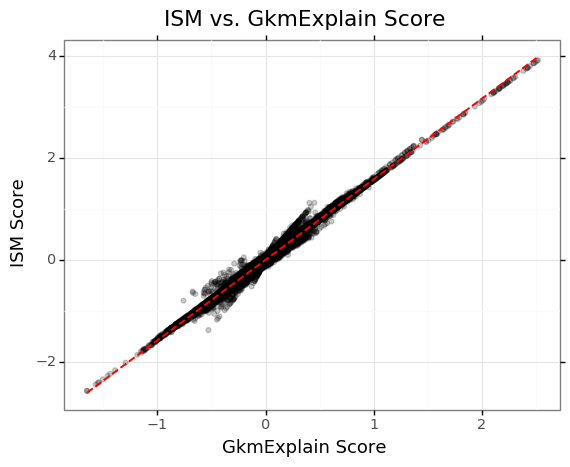

<ggplot: (8735800421938)>

In [6]:
p1 = ((ggplot(merged, aes(x='explain', y='ism'))
         + geom_point(alpha=0.2)
         + stat_smooth(method='lm', linetype='dashed', size=0.8, color='red')
         + theme_bw(13)
         + xlab('GkmExplain Score')
         + ylab('ISM Score')
         + ggtitle('ISM vs. GkmExplain Score')))
display(p1)

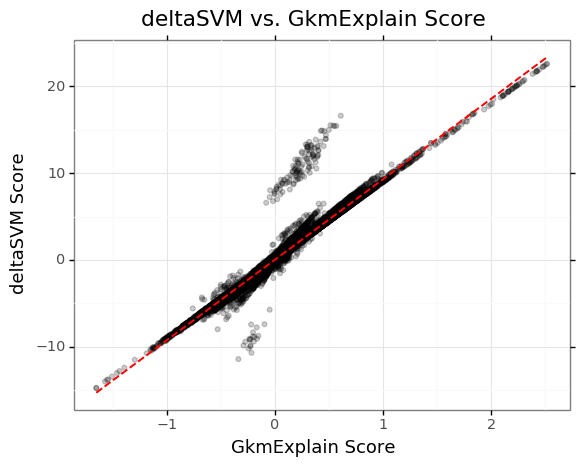

<ggplot: (8735800860522)>

In [7]:
p2 = ((ggplot(merged, aes(x='explain', y='delta'))
         + geom_point(alpha=0.2)
         + stat_smooth(method='lm', linetype='dashed', size=0.8, color='red')
         + theme_bw(13)
         + xlab('GkmExplain Score')
         + ylab('deltaSVM Score')
         + ggtitle('deltaSVM vs. GkmExplain Score')))
display(p2)

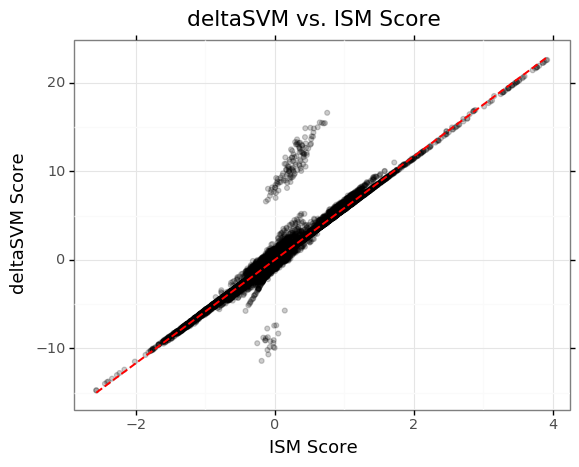

<ggplot: (8735800720630)>

In [8]:
p3 = ((ggplot(merged, aes(x='ism', y='delta'))
         + geom_point(alpha=0.2)
         + stat_smooth(method='lm', linetype='dashed', size=0.8, color='red')
         + theme_bw(13)
         + xlab('ISM Score')
         + ylab('deltaSVM Score')
         + ggtitle('deltaSVM vs. ISM Score')))
display(p3)

In [9]:
p1.save('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/score_plots/ism_vs_gkmexplain.svg')
p2.save('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/score_plots/deltasvm_vs_gkmexplain.svg')
p3.save('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/score_plots/deltasvm_vs_ism.svg')

In [10]:
outliers = merged[((merged['delta'] > 7) & (merged['ism'] < 0.7)) | ((merged['delta'] < -7) & (merged['ism'] > -0.5))]
outliers.sort_values(by=['locus_num','delta'], ascending=False, inplace=True)
display(outliers.head())

,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gwas,gwas_pval,snp_cluster,snp_fold,snp_index,explain,ism,delta
2766,chr17,46213482,46213483,rs76475191,T,A,T,A,T,A,+,54,23andme_PD_hg38,1.102030e-18,1,4,318,0.515425,0.64477,15.51668
3900,chr17,46213482,46213483,rs76475191,T,A,T,A,T,A,+,54,23andme_PD_hg38,1.102030e-18,1,6,318,0.541002,0.67636,15.46170
2199,chr17,46213482,46213483,rs76475191,T,A,T,A,T,A,+,54,23andme_PD_hg38,1.102030e-18,1,3,318,0.499488,0.61419,14.97028
1065,chr17,46213482,46213483,rs76475191,T,A,T,A,T,A,+,54,23andme_PD_hg38,1.102030e-18,1,1,318,0.436863,0.51020,14.91097
47852,chr17,46213482,46213483,rs76475191,T,A,T,A,T,A,+,54,23andme_PD_hg38,1.102030e-18,15,3,201,0.425843,0.43644,14.85950


In [11]:
display(outliers['rsid'].unique())

array(['rs76475191', 'rs78826239', 'rs200791233'], dtype=object)

In [12]:
fixed = merged[(merged['rsid'] != 'rs76475191') & (merged['rsid'] != 'rs78826239') & (merged['rsid'] != 'rs200791233')]
display(fixed.head())

,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gwas,gwas_pval,snp_cluster,snp_fold,snp_index,explain,ism,delta
0,chr19,44643845,44643846,19_44643846,A,G,.,.,.,.,+,71,Alzheimers_Kunkle_2019,7.420000e-23,1,0,360,0.066697,0.094091,0.484260
1,chr19,44890946,44890947,19_44890947,A,G,.,.,.,.,+,71,Alzheimers_Jansen_2018,9.357000e-19,1,0,375,-0.427551,-0.674378,-3.918473
2,chr19,45117771,45117772,19_45117772,NAN,NAN,.,.,.,.,.,71,,1.000000e+00,1,0,411,0.000000,0.000000,0.000000
3,chr2,127107527,127107528,2_127107528,NAN,NAN,.,.,.,.,.,77,,1.000000e+00,1,0,451,0.000000,0.000000,0.000000
4,chr4,89774356,89774357,rs10025915,G,A,G,A,G,A,-,103,23andme_PD_hg38,3.440990e-22,1,0,555,-0.196409,-0.308999,-1.807510


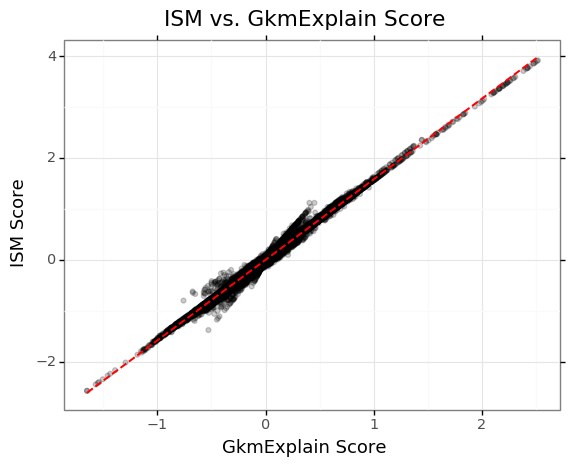

<ggplot: (-9223363301053583714)>

In [13]:
p4 = ((ggplot(fixed, aes(x='explain', y='ism'))
         + geom_point(alpha=0.2)
         + stat_smooth(method='lm', linetype='dashed', size=0.8, color='red')
         + theme_bw(13)
         + xlab('GkmExplain Score')
         + ylab('ISM Score')
         + ggtitle('ISM vs. GkmExplain Score')))
display(p4)

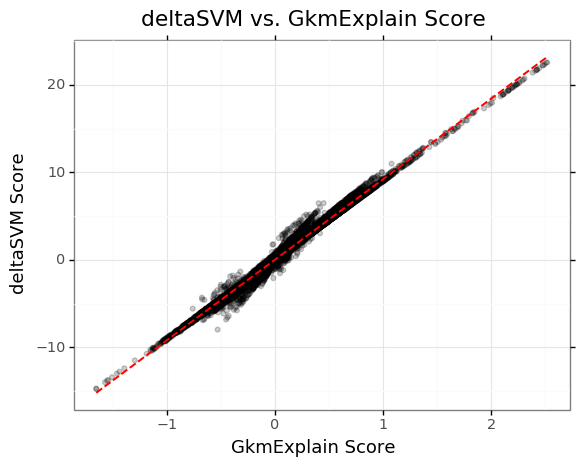

<ggplot: (8735801251241)>

In [14]:
p5 = ((ggplot(fixed, aes(x='explain', y='delta'))
         + geom_point(alpha=0.2)
         + stat_smooth(method='lm', linetype='dashed', size=0.8, color='red')
         + theme_bw(13)
         + xlab('GkmExplain Score')
         + ylab('deltaSVM Score')
         + ggtitle('deltaSVM vs. GkmExplain Score')))
display(p5)

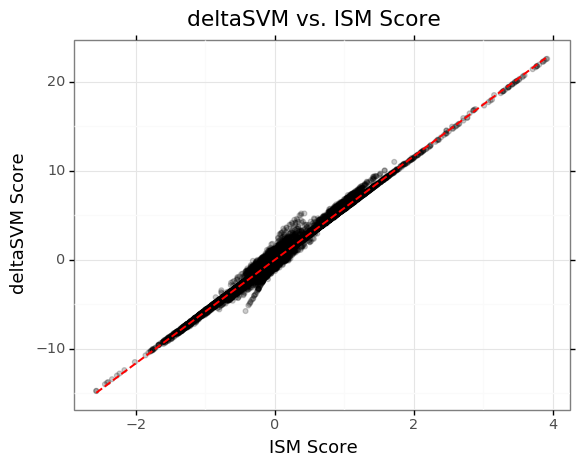

<ggplot: (-9223363301054264544)>

In [15]:
p6 = ((ggplot(fixed, aes(x='ism', y='delta'))
         + geom_point(alpha=0.2)
         + stat_smooth(method='lm', linetype='dashed', size=0.8, color='red')
         + theme_bw(13)
         + xlab('ISM Score')
         + ylab('deltaSVM Score')
         + ggtitle('deltaSVM vs. ISM Score')))
display(p6)

In [16]:
p4.save('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/score_plots/ism_vs_gkmexplain_corrected.svg')
p5.save('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/score_plots/deltasvm_vs_gkmexplain_corrected.svg')
p6.save('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/score_plots/deltasvm_vs_ism_corrected.svg')

In [17]:
merged.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/all_svm_scores.csv', sep='\t', index=False)